# rare vs common variants and genes

purpose: this notebook is used to compare the variants and genes from rare and common datasets directly (not in network space)
analyses:
    - manhattan and porcupine plots for rare variants and genes
    - burden types in rare genes
Figures generated:
- Figure 1
- Figure S2
- source for Fig S
Tables generated:


# setup

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import upsetplot
import math
import statistics as stat
import numpy as np
import scipy.stats as stats
import statsmodels.stats.multitest
from upsetplot import plot as upplot
from upsetplot import from_contents
from upsetplot import UpSet
from matplotlib_venn import venn3
from rca_functions import *

In [2]:
matplotlib.rcParams.update({'font.size': 8})
matplotlib.rcParams.update({'figure.dpi':500})

In [3]:
import os
os.chdir('..')
os.getcwd()

'/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison'

In [4]:
save_fig=False

# import variant tables

In [ ]:
#import common variants
common=pd.read_csv('input_files/GSCAN_DPW/GSCAN_DrnkWk_2022_GWAS_SUMMARY_STATS_EUR.txt.gz',compression='gzip', sep='\t')

In [ ]:
#filtered for MAF cutoff
rare=pd.read_csv('input_files/rare_variant_genebass/alcohol_intake/alcohol_intake_variant_tbl_maf05.tsv.gz',compression='gzip',sep='\t',low_memory=False)
#filter for those with greater than 2 Minor allele counts to reduce number of artifacts
rare=rare[rare['call_stats.AC']>2].reset_index()

## filter variants

In [ ]:
common['CHR']=common['CHR'].map(lambda x: x.lstrip('chr'))

In [ ]:
common_cutoff=5e-8

In [ ]:
rare_cutoff=8e-9

# import gene tables

In [5]:
stringent_skato=2.5e-7
stringent_skat= 2.5e-7
stringent_burden=6.7e-7

In [6]:
common_datasets=pd.read_csv('common_datasets_prepub.csv',sep=',')
rare_datasets=pd.read_csv('rare_datasets_prepub.csv',sep=',')

### common

In [7]:
#read in gene level associations from common variants
row_common=common_datasets[common_datasets['label']=='GSCAN_DPW_magma'].index[0]
common_genes=import_seedgenes(path=common_datasets['seed_path'][row_common],
                pcol=common_datasets['seed_p'][row_common],
                gene_col=common_datasets['seed_gene_name'][row_common],
                delim=common_datasets['delim'][row_common],
                cutoff=None)
common_genes_cutoff=0.05/len(common_genes)
common_genes['plt']=(common_genes['START']+common_genes['STOP'])/2
common_genes_sig=common_genes[common_genes['P']<common_genes_cutoff]

cutoff not defined/custom- using all genes 
        GENE  CHR   START    STOP  NSNPS  NPARAM       N    ZSTAT        P  \
0      79501    1   59091   80008      6       3  436159 -0.39952  0.65525   
1  100996442    1  131934  184394      5       3  437867  0.23430  0.40738   
2  105378947    1  576287  621297      7       4  444770 -0.45845  0.67668   
3      81399    1  675716  696654      2       1  405668  0.83144  0.20286   
4  105378580    1  793398  815130     71      19  473562  0.52224  0.30075   

      GENE_NAME  
0         OR4F5  
1  LOC100996442  
2  LOC105378947  
3        OR4F16  
4  LOC105378580  


### rare

In [8]:
#read in gene level associations from rare variants- all genes not just seed genes
rare_genes=pd.read_csv('input_files/rare_variant_genebass/alcohol_intake/alcohol_intake_variants_filtered.csv')
#rare_genes=rare_genes.reindex()
rare_genes

,Gene Name,Gene Id,P‑Value SKATO,P‑Value Burden,P‑Value SKAT,BETA Burden,Burden Set,Chrom : Position,Chrom,Position
0,PMM2,ENSG00000140650,1.350000e-07,2.370000e-07,0.000003,-0.002303,missense|LC,1.600880e+10,16,8795849.0
1,SLC29A1,ENSG00000112759,1.143640e-05,2.248690e-05,0.000036,0.002125,missense|LC,6.044220e+09,6,44219628.0
2,SCN7A,ENSG00000136546,2.273180e-05,5.111642e-02,0.000011,0.000497,missense|LC,2.166406e+09,2,166405531.0
3,ATP2B1,ENSG00000070961,2.806750e-05,4.360580e-05,0.000238,-0.002661,missense|LC,1.208959e+10,12,89590911.0
4,MMEL1,ENSG00000142606,3.676450e-05,1.690100e-05,0.002806,0.001404,missense|LC,1.002587e+09,1,2586658.0
...,...,...,...,...,...,...,...,...,...,...
56310,AC010197.2,ENSG00000285854,1.000000e+00,8.396620e-01,0.835495,-0.000271,synonymous,1.202153e+10,12,21531210.0
56311,AC083977.1,ENSG00000286131,1.000000e+00,8.710636e-01,0.982191,-0.000623,synonymous,8.032647e+09,8,32646604.0
56312,DERPC,ENSG00000286140,1.000000e+00,8.545748e-01,0.803689,-0.000922,synonymous,1.606911e+10,16,69113413.0
56313,AC022137.3,ENSG00000286261,1.000000e+00,9.306755e-01,0.963149,0.000259,synonymous,1.905344e+10,19,53441833.0


In [9]:
#expand rare genes table so each gene list listed individually- for porcupine plot
rare_genes['pvals']='Burden:'+rare_genes['P‑Value Burden'].astype('string')+','+'SKATO:'+rare_genes['P‑Value SKATO'].astype('string')+','+'SKAT:'+rare_genes['P‑Value SKAT'].astype('string')
rare_genes['pvals']=rare_genes['pvals'].str.split(',')
rare_genes_exploded=rare_genes.explode('pvals', ignore_index=True)
rare_genes_exploded[['test','pvals']]=rare_genes_exploded['pvals'].str.split(':',expand=True)
rare_genes_exploded['pvals']=rare_genes_exploded['pvals'].astype('float')

In [10]:
#calculate FDR for cutoffs
rare_genes['FDR_SKATO']=statsmodels.stats.multitest.fdrcorrection(rare_genes['P‑Value SKATO'],alpha=0.05,method='indep',is_sorted=False)[1]
rare_genes['FDR_SKAT']=statsmodels.stats.multitest.fdrcorrection(rare_genes['P‑Value SKAT'],alpha=0.05,method='indep',is_sorted=False)[1]
rare_genes['FDR_burden']=statsmodels.stats.multitest.fdrcorrection(rare_genes['P‑Value Burden'],alpha=0.05,method='indep',is_sorted=False)[1]

In [ ]:
rare['beta_zscore']=stats.zscore(rare['BETA'])
common['beta_zscore']=stats.zscore(common['BETA'])
#check if any common variants are rare- they arent
len(common)- len(common[common['AF_1000G']>0.001])
#select only significant genes
common_sig=common[common['P']<common_cutoff]

In [ ]:
tblr=rare['beta_zscore']
tblc=common['beta_zscore']
tblr_label='rare variants'
tblc_label='common_variants'
bins=100

ax1=plt
ax1.figure(figsize=(5,2))
ax1.hist(tblr, bins=bins, alpha=0.7, density=True, label=tblr_label, color=color_dict['rare'], range=(-4,4))
ax1.hist(tblc,bins=bins, alpha=0.7, density=True, label=tblc_label, color=color_dict['common'], range=(-4,4))

ax1.ylabel("density")
ax1.xlabel("beta (z)")
if save_fig:
    plt.savefig('figures/' + 'betazscore_histogram_variants_long.svg',bbox_inches='tight')

In [ ]:
#compute the variance of rare vs common 
print('variance rare: ',np.var(tblr),'variance common: ', np.var(tblc))
#test if there's a significant difference in the distributions of common and rare beta values (z-score normalized)

f=f_test(tblr, tblc)
print("rare over common variance: "+str(f[0]))
print("significance (p-value) of difference between rare and common variance: "+str(f[1]))
if f[1]<0.05:
    print("variance is significantly different")
else:
    print("variance is not significantly different")

# manhattan plot

## common variant level manhattan - Fig 1A

In [ ]:
fig=plt.figure(figsize=(10,4))
manhattan(pval=common['P'],pos=common['POS'],chr=common['CHR'],label='',
                    cut=0,lines=[-np.log10(5e-8)],lines_colors=['red'], colors=[color_dict['common'], color_dict['common_alt']],
                    lines_widths = [2], lines_styles = ["--"],
                   top=50, markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.xticks(rotation='vertical')
fig=plt.ylabel('common variant -log10(p)')
if save_fig:
    #plt.savefig('figures/' + 'common_variants'+'_zoom50_5e-8'+'.svg',bbox_inches='tight')
    plt.savefig('figures/' + 'common_variants'+'_zoom50_5e-8'+'_500dpi.png',dpi=500,bbox_inches='tight')

In [23]:
np.unique(common_genes['CHR'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22])

## common gene level manhattan- Fig 1C

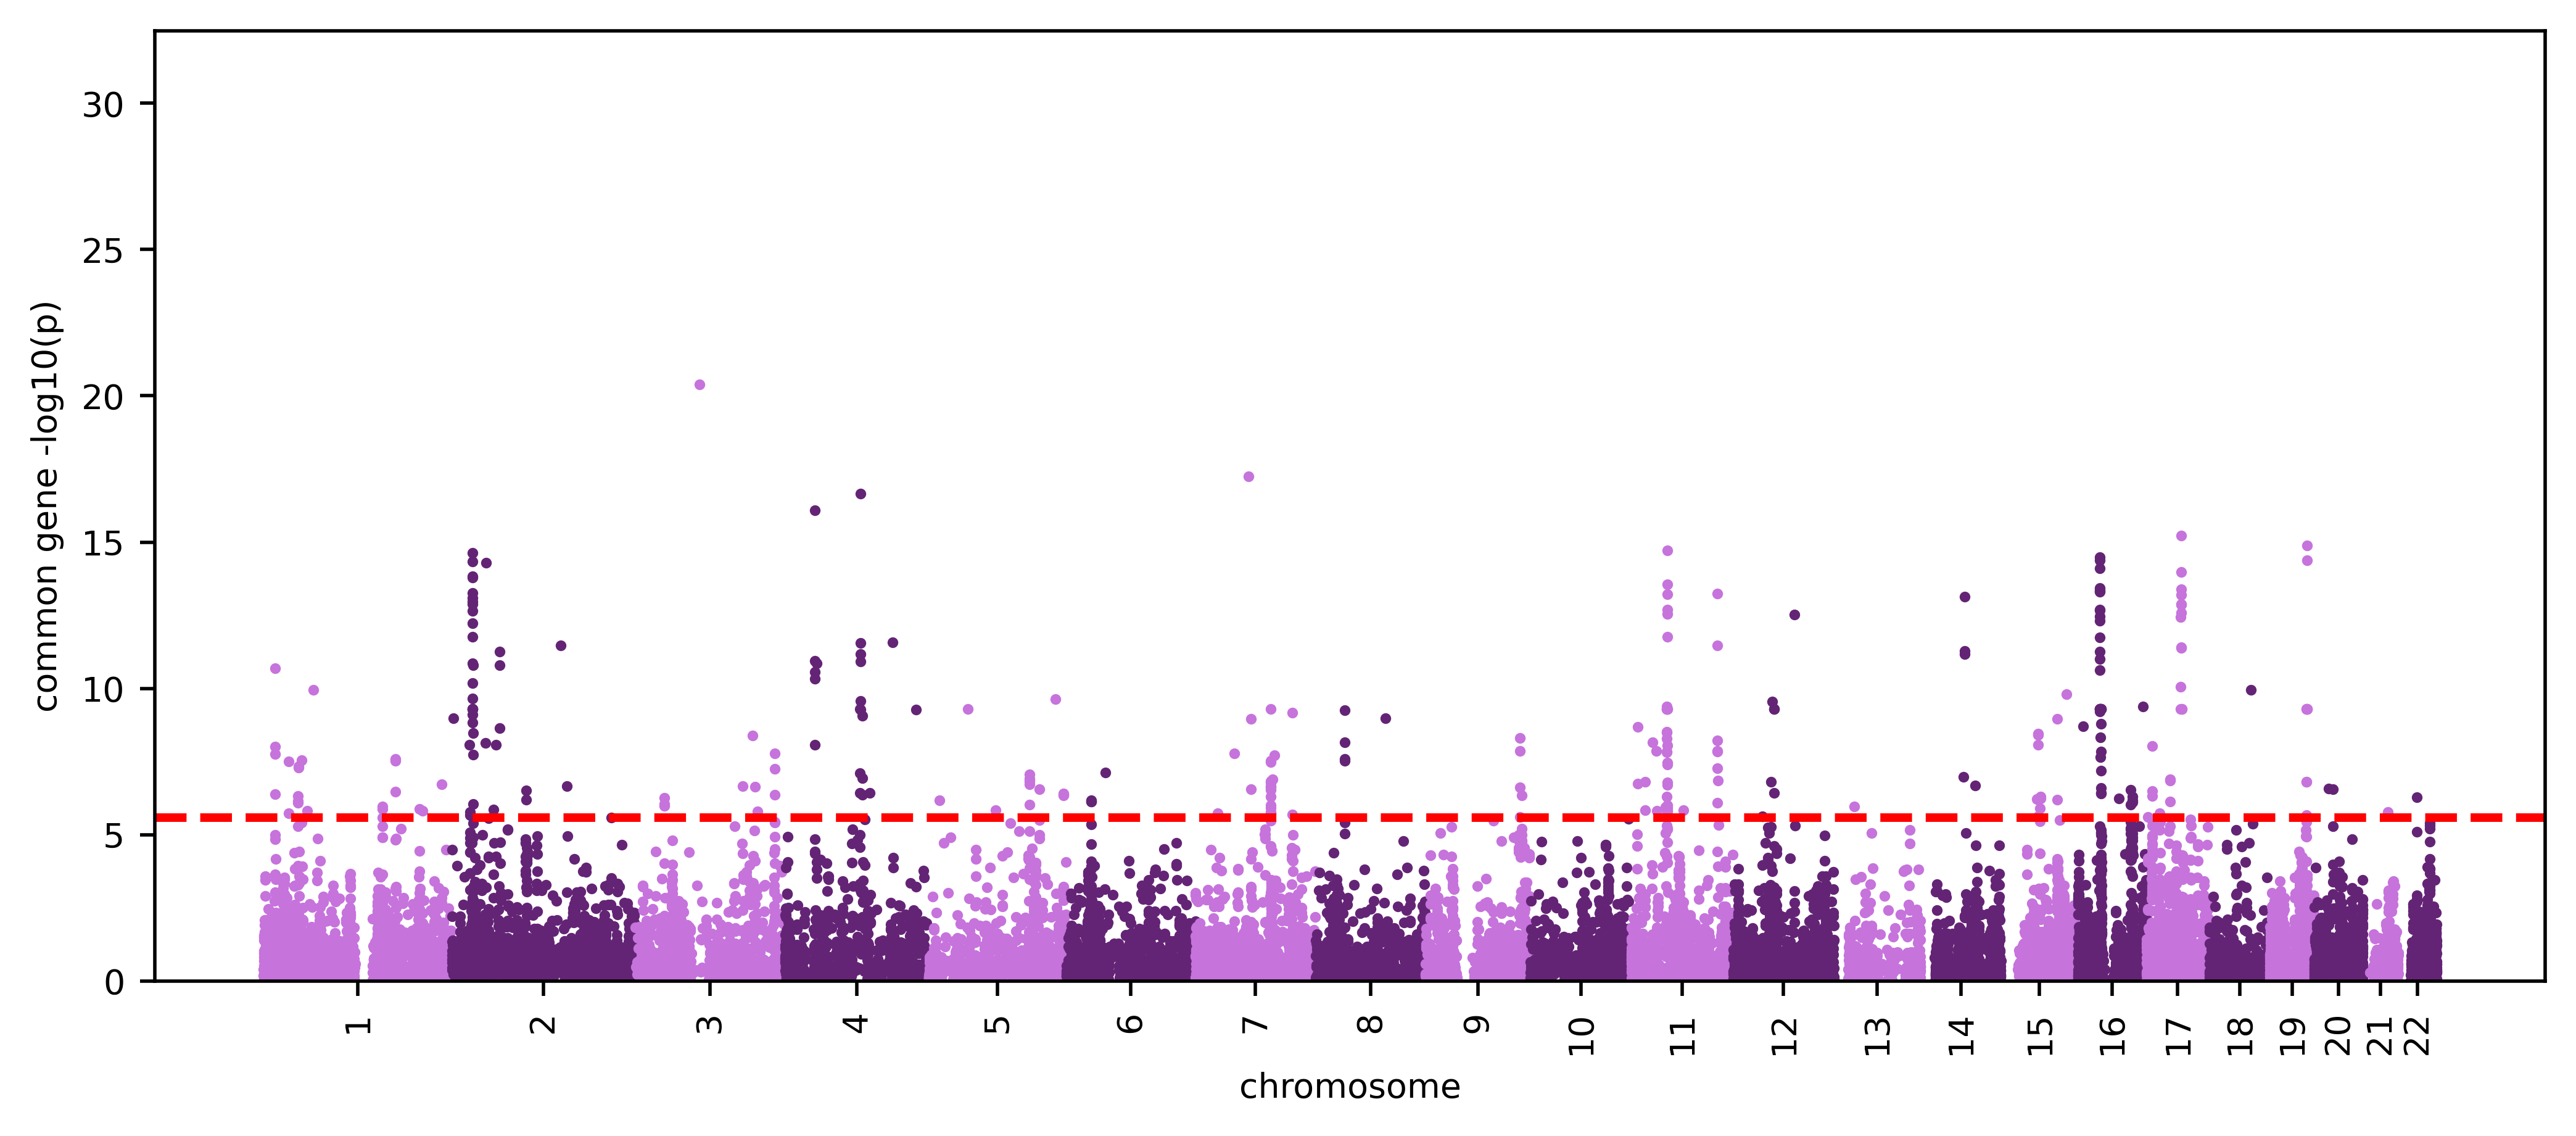

In [12]:
fig=plt.figure(figsize=(10,4))
#fig, ax=plt.subplots(figsize=(10,4))
manhattan(pval=common_genes['P'],pos=common_genes['plt'],chr=common_genes['CHR'],label='',
                    cut=0,lines=[-np.log10(0.05/len(common_genes))],lines_colors=['red'], colors=[color_dict['common'], color_dict['common_alt']],
                    lines_widths = [2], lines_styles = ["--"],
                   top=-np.log10(min(rare_genes_exploded['pvals'])), markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('common gene -log10(p)')

#commented out- use to turn into miami plot
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')
if save_fig:
    #plt.savefig('figures/' + 'common_genes'+'_zoom35_bonf'+'.svg',bbox_inches='tight')
    plt.savefig('figures/' + 'common_genes'+'_zoom35_bonf'+'_500dpi.png',dpi=500,bbox_inches='tight')

In [ ]:
#used in the graphical abstract
fig=plt.figure(figsize=(10,4))
#fig, ax=plt.subplots(figsize=(10,4))
manhattan(pval=common_genes['P'],pos=common_genes['plt'],chr=common_genes['CHR'],label='',
                    cut=0,lines=[-np.log10(0.05/len(common_genes))],lines_colors=['red'], colors=[color_dict['common'], color_dict['common_alt']],
                    lines_widths = [2], lines_styles = ["--"],
                   top=-np.log10(min(rare_genes_exploded['pvals'])), markersize=6, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('common gene -log10(p)')

#commented out- use to turn into miami plot
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')
if save_fig:
    plt.savefig('figures/' + 'common_genes'+'_abstract'+'_500dpi.png',dpi=500,bbox_inches='tight')

## rare variant manhattan- Fig 1B

In [ ]:
fig=plt.figure(figsize=(10,4))
manhattan(pval=rare['Pvalue'],pos=rare['POS'],chr=rare['CHR'],label='',
                    cut=0,lines=[-np.log10(8e-9)],lines_colors=['red'], colors=[color_dict['rare'], color_dict['rare_alt']],
                    lines_widths = [2], lines_styles = ["--"],
                   top=10, markersize=3, plot_grid_lines=False)

fig1=plt.title('')
fig1=plt.xticks(rotation='vertical')
fig1=plt.ylabel('rare variant -log10(p)')
if save_fig:
    #plt.savefig('figures/' + 'rare_variants'+'_bonf'+'_10_short.svg',bbox_inches='tight')
    plt.savefig('figures/' + 'rare_variants'+'_bonf'+'_10_short_500dpi.png',dpi=500,bbox_inches='tight')

## rare gene single-test manhattan- Fig S2A

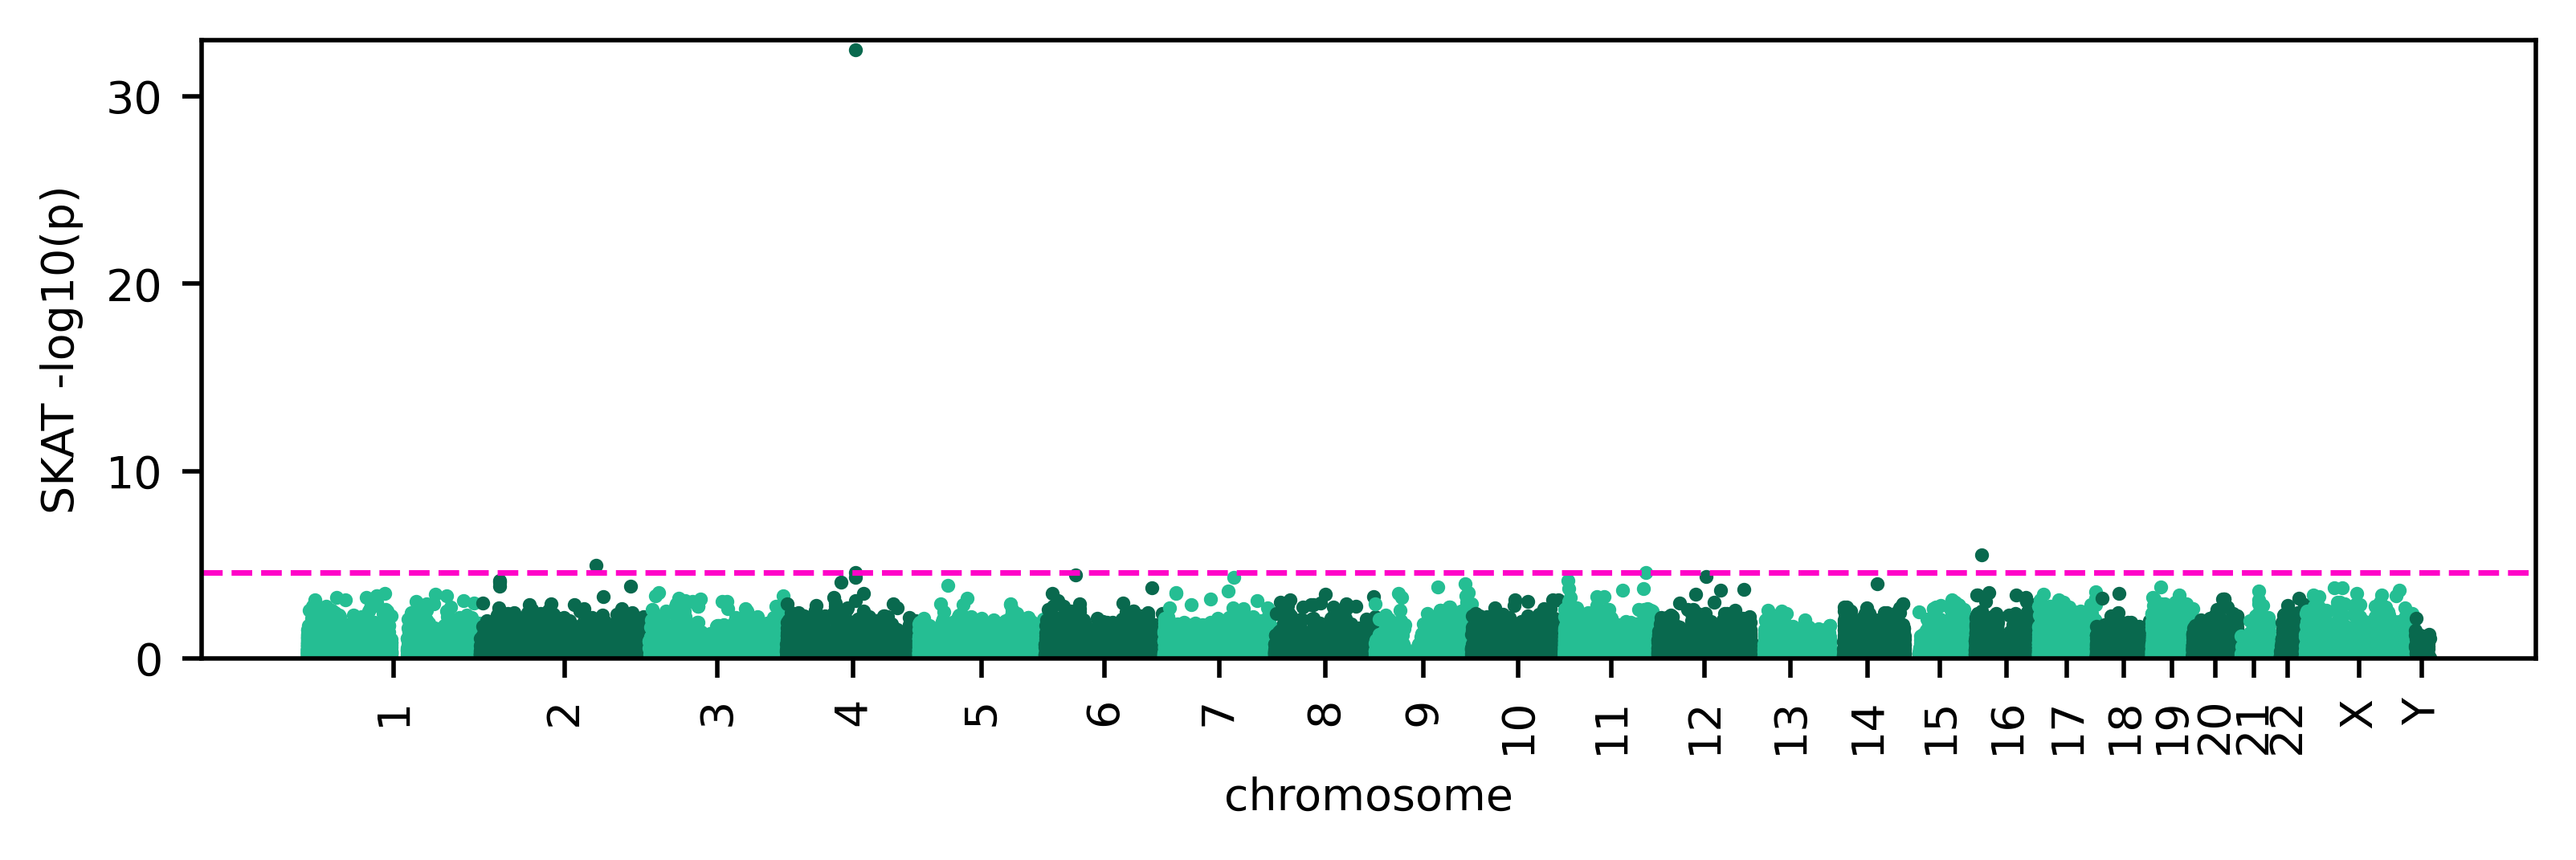

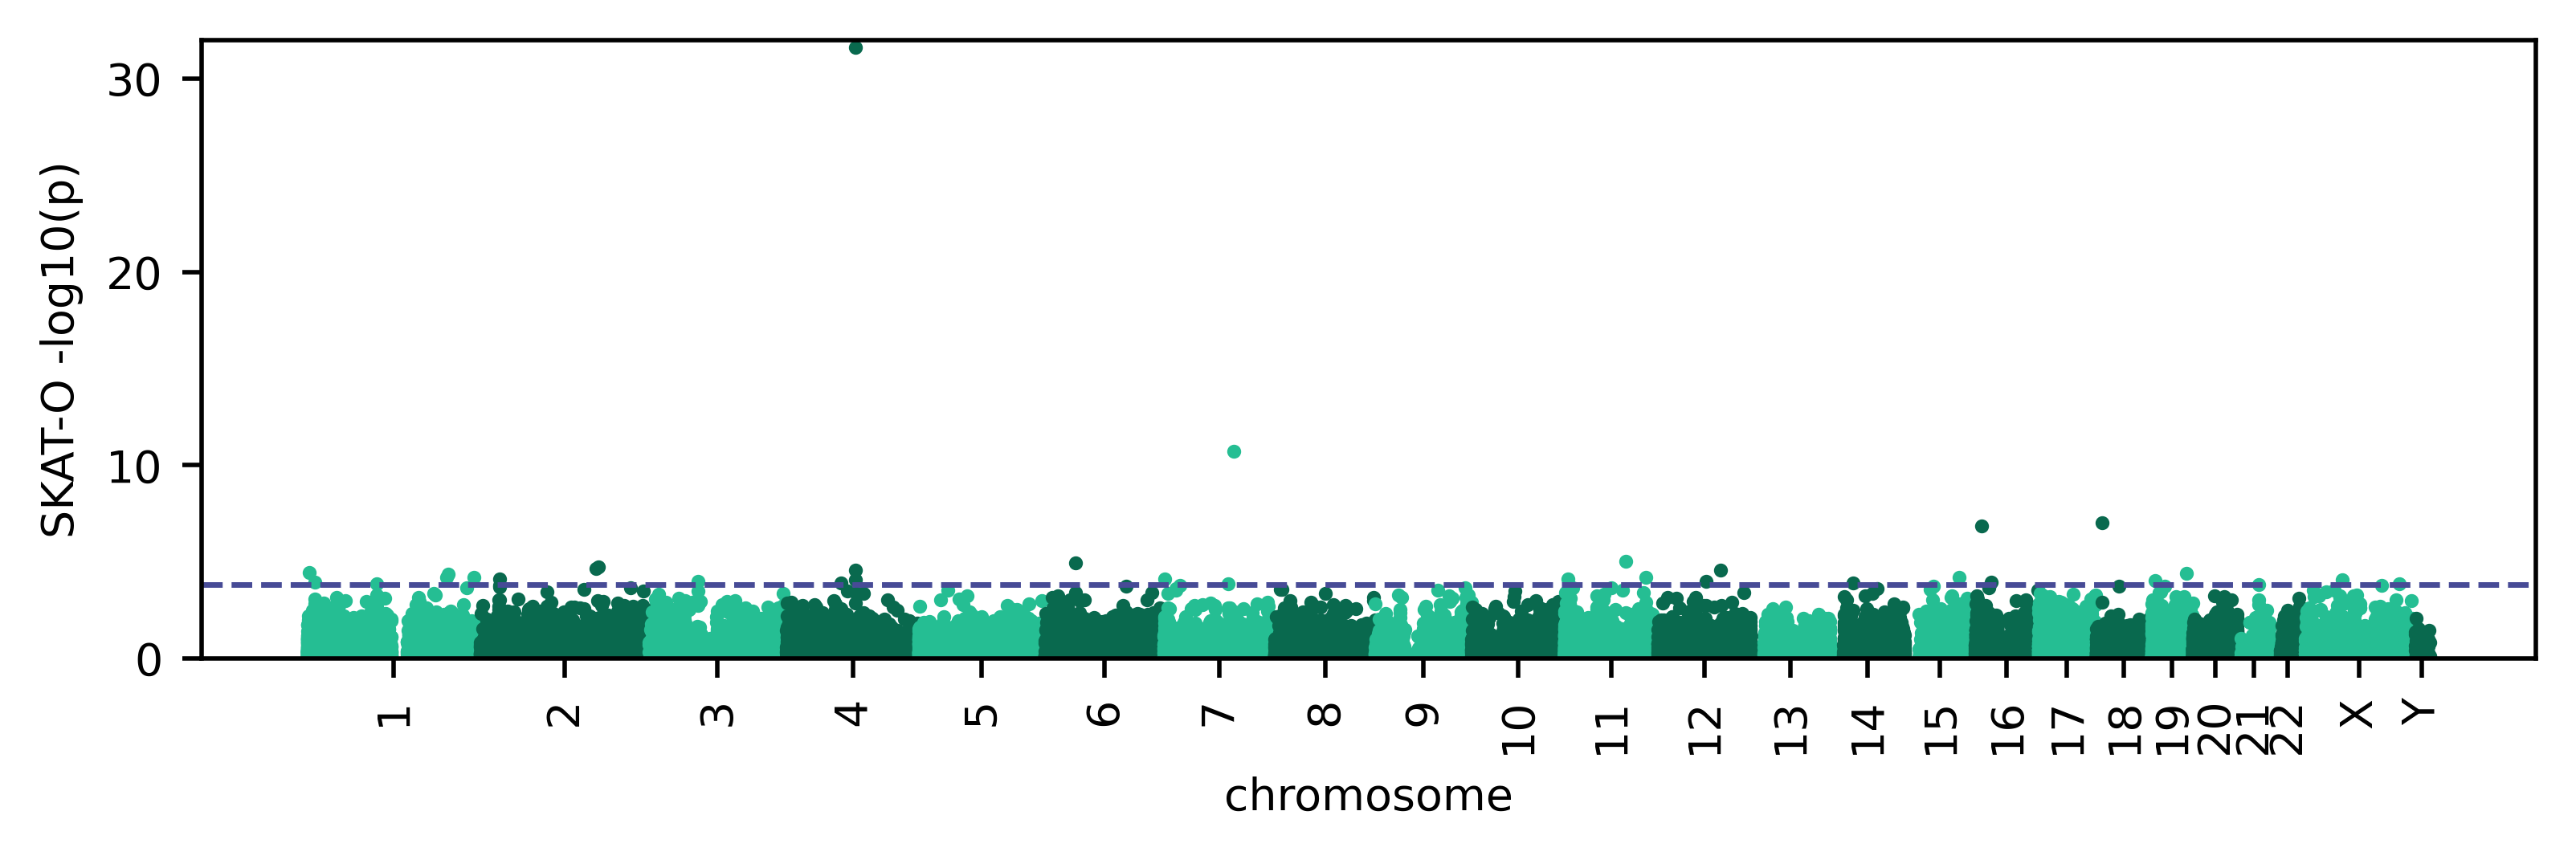

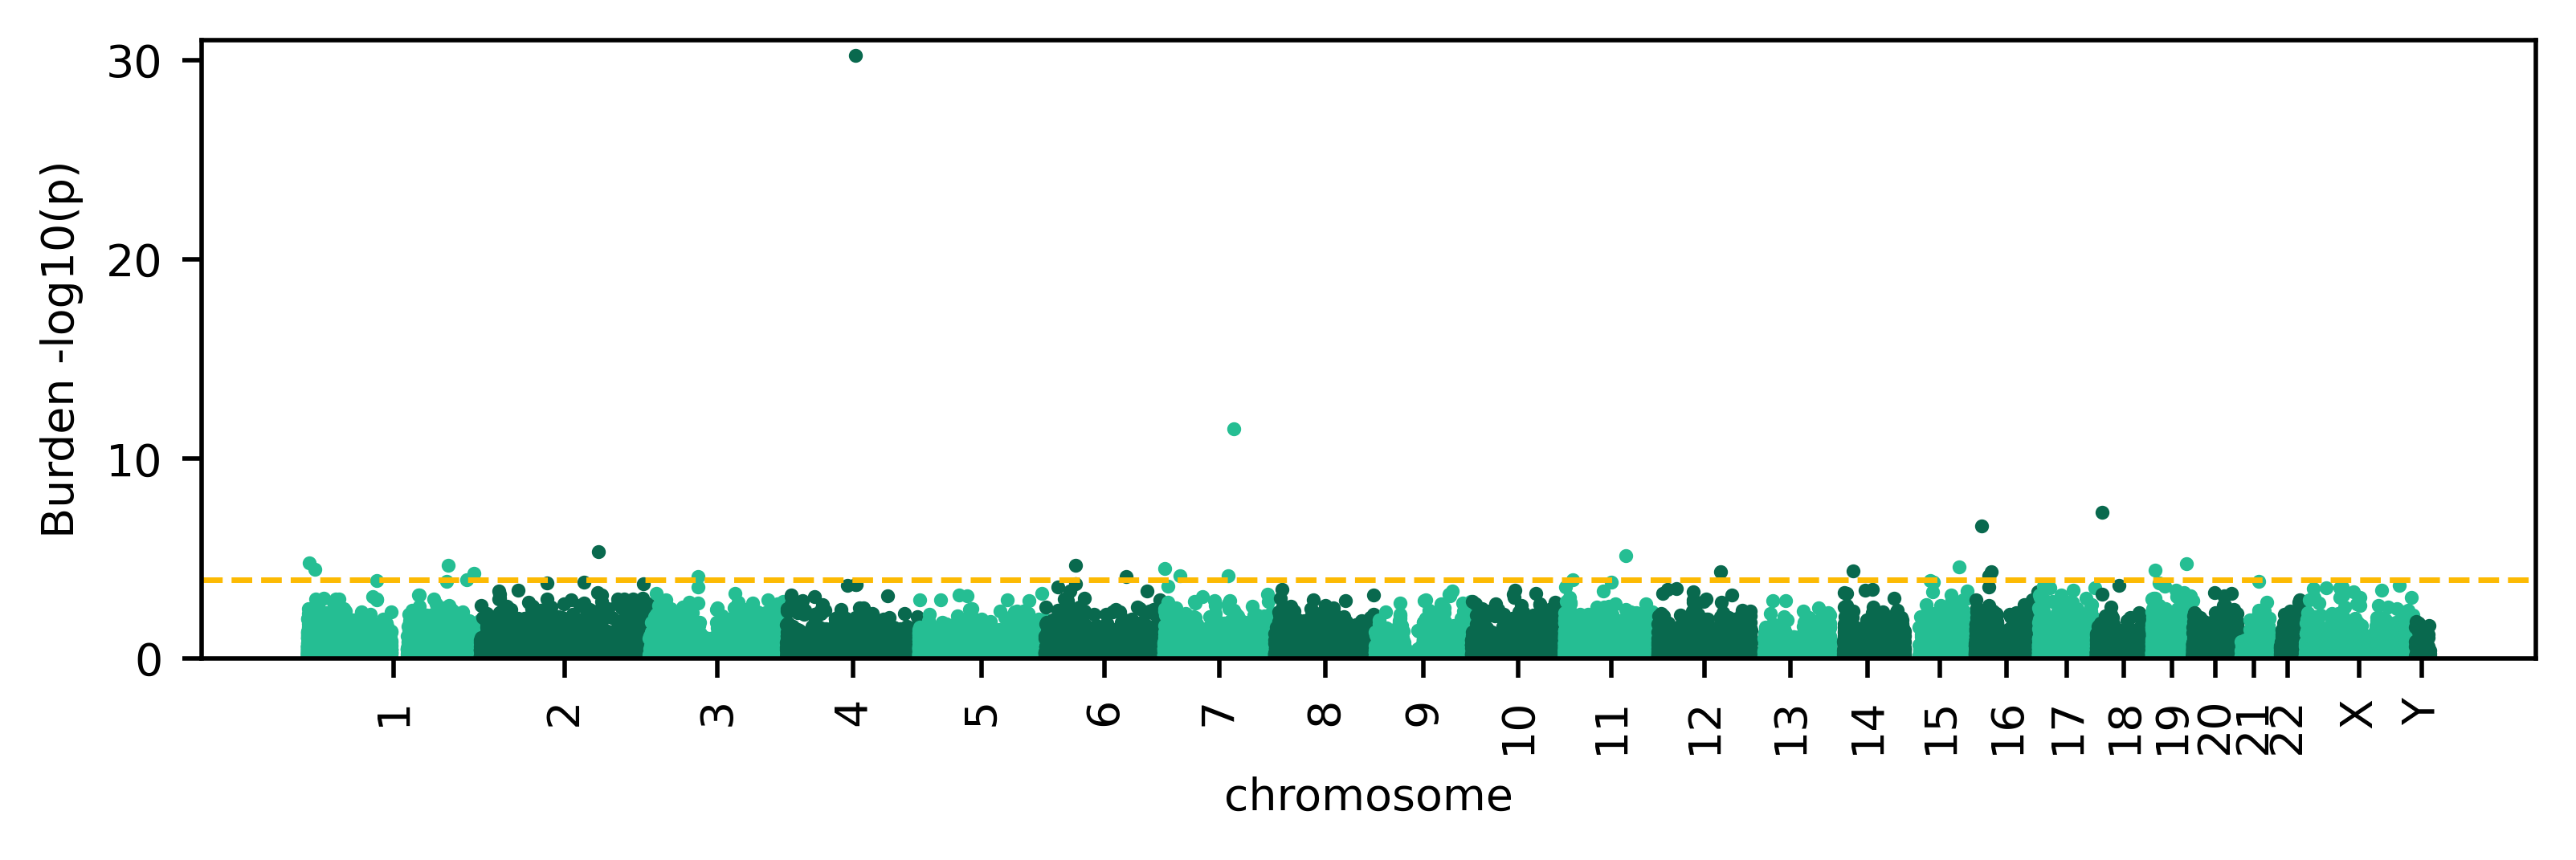

In [13]:
rare_cutoff_dict={'SKAT':2.7e-5,
'SKAT-O':1.5e-4,
'burden':1.1e-4}
test_col={'SKAT':'P‑Value SKAT',
'SKAT-O':'P‑Value SKATO',
'burden':'P‑Value Burden'
}

for k in rare_cutoff_dict.keys():
    fig=plt.figure(figsize=(7.5,2))
    manhattan(pval=rare_genes[test_col[k]],pos=rare_genes['Position'],chr=rare_genes['Chrom'],label='',
                cut=0,lines=[-np.log10(rare_cutoff_dict[k])],lines_colors=[color_dict[k]], colors=[color_dict['rare'], color_dict['rare_alt']],
                lines_widths = [1],lines_styles = ["--"],
               top=0, markersize=3, plot_grid_lines=False)
    if k=='burden':
        lab='Burden -log10(p)'
    else:
        lab=k+' -log10(p)'
    fig=plt.title('')
    fig=plt.ylabel(lab)
    fig=plt.xticks(rotation='vertical')   
    if save_fig:
        #plt.savefig('figures/' + 'rare_genes_'+k+'.svg',bbox_inches='tight')
        plt.savefig('figures/' + 'rare_genes_'+k+'_500dpi.png',dpi=500,bbox_inches='tight')

## porcupine plot rare genes (all 3 tests)- Fig 1D

In [14]:
FDR_skato_25=min(rare_genes[(rare_genes['FDR_SKATO']>=0.25)]['P‑Value SKATO'])
FDR_skat_25=min(rare_genes[(rare_genes['FDR_SKAT']>=0.25)]['P‑Value SKAT'])
FDR_burden_25=min(rare_genes[(rare_genes['FDR_burden']>=0.25)]['P‑Value Burden'])

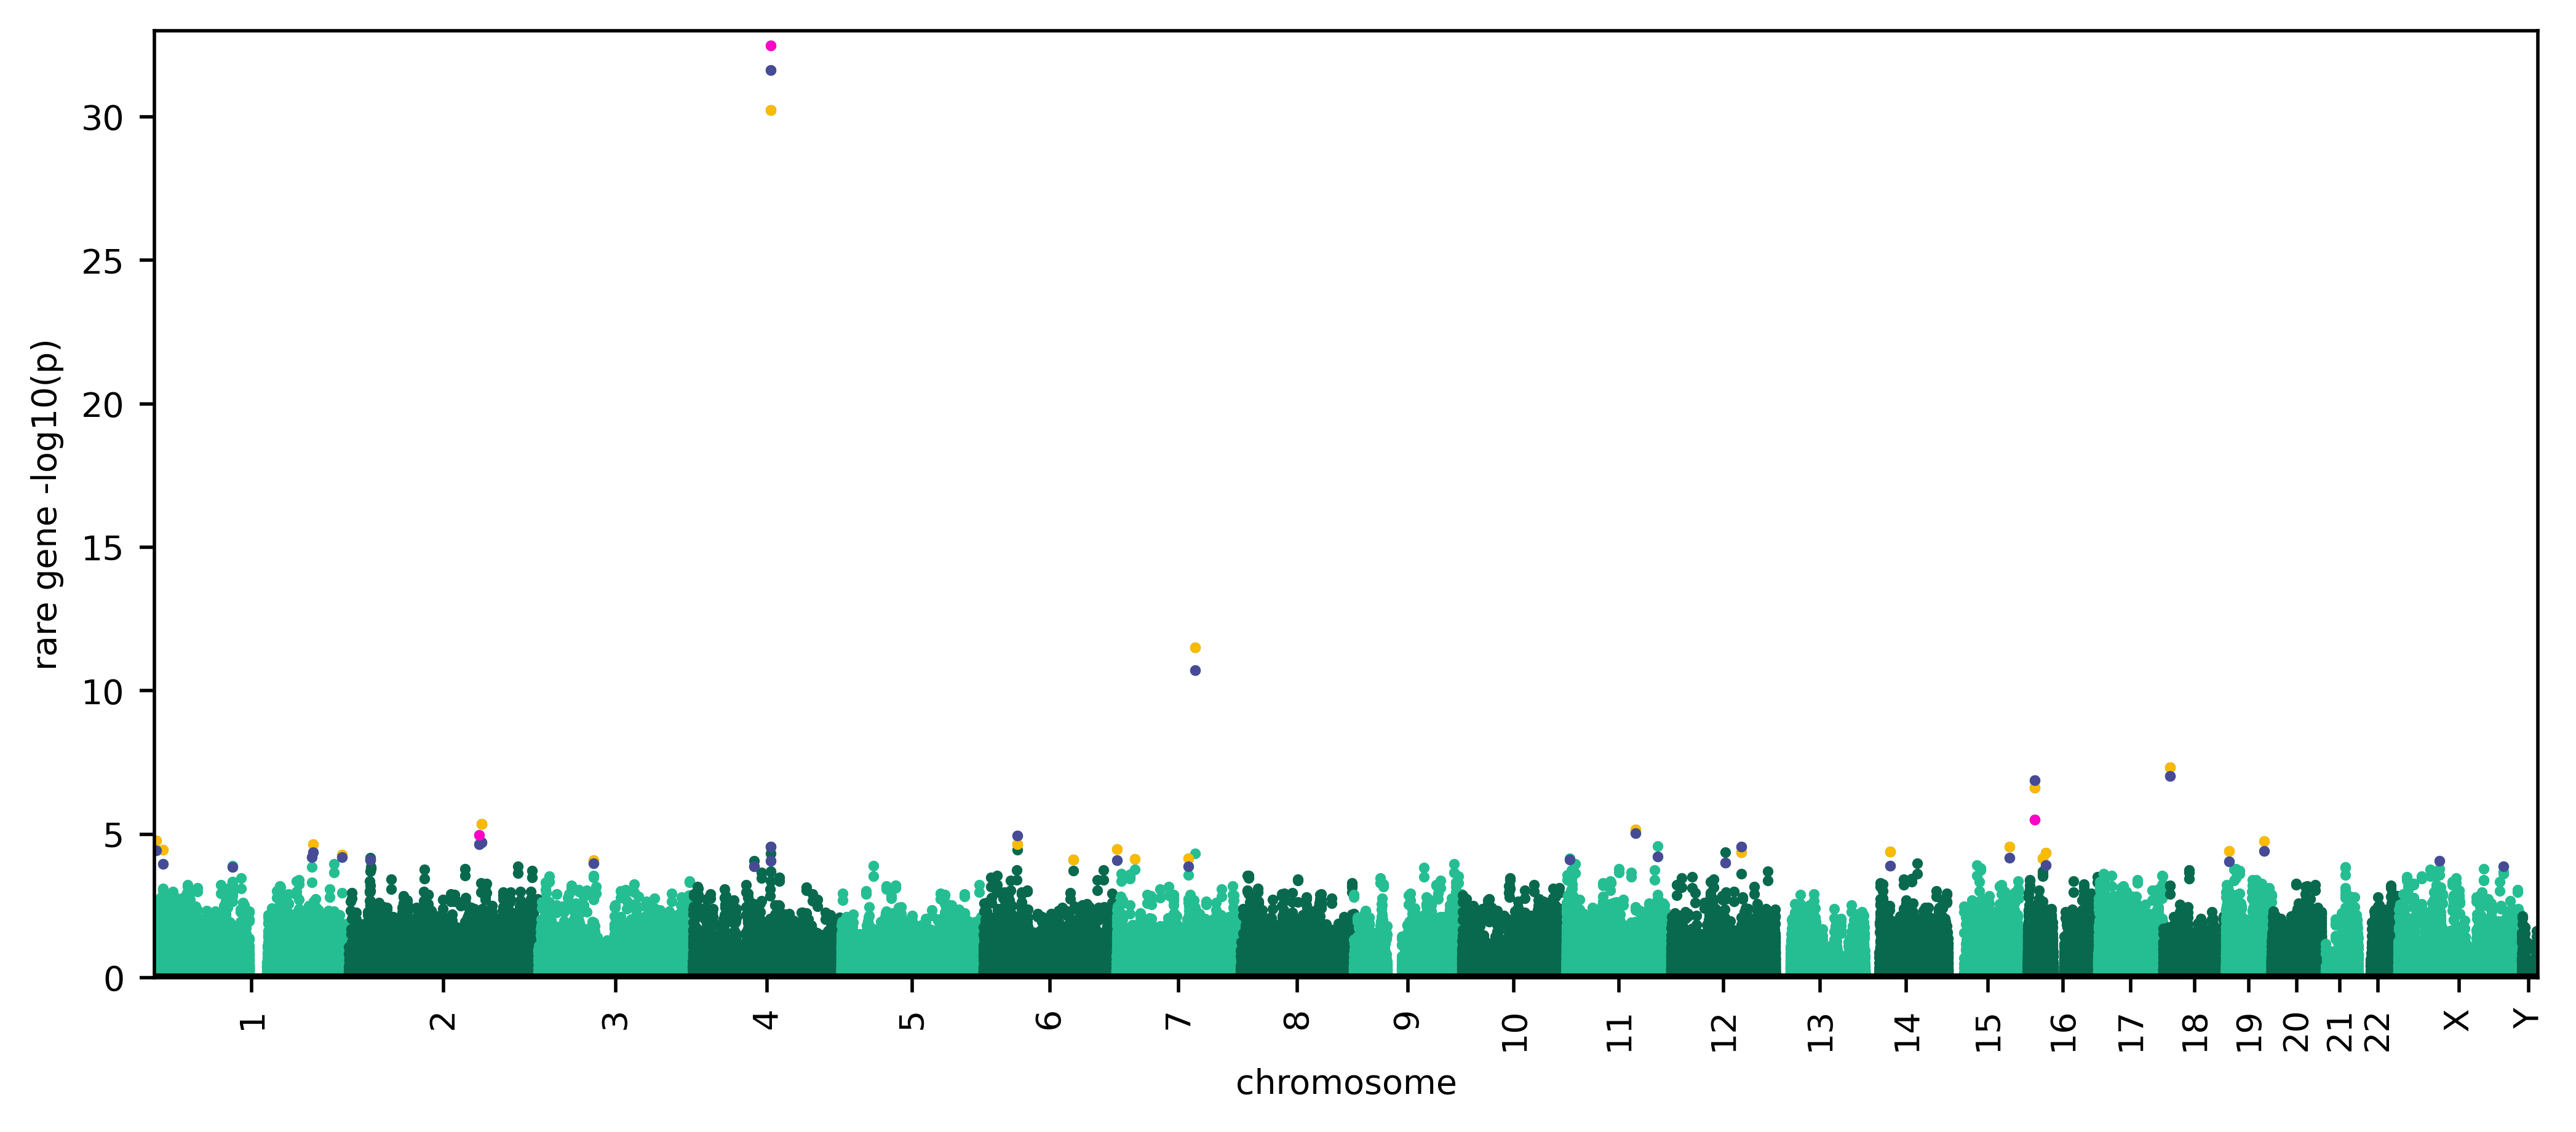

In [15]:
fig=plt.figure(figsize=(10,4))
#fig, ax=plt.subplots(figsize=(10,4))

porcupine(pval=rare_genes_exploded['pvals'],test=rare_genes_exploded['test'],
          pos=rare_genes_exploded['Position'],
          chr=rare_genes_exploded['Chrom'],label='',
          cut_SKATO=FDR_skato_25, cut_SKAT=FDR_skat_25, cut_burden=FDR_burden_25, 
          cut=0,lines=[0],lines_colors=['Black'], colors=[color_dict['rare'], color_dict['rare_alt']],
          lines_widths = [2],top=0, markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('rare gene -log10(p)')
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')
#plt.savefig('figures/' + 'invert_rare_genes'+'_bonf_all'+'.svg',bbox_inches='tight')
#plt.savefig('figures/' + 'invert_rare_genes'+'_bonf_all'+'_500dpi.png',dpi=500,bbox_inches='tight')
if save_fig:
    #plt.savefig('figures/' + 'rare_genes'+'_FDR_25'+'_short.svg',bbox_inches='tight')
    plt.savefig('figures/' + 'rare_genes'+'_FDR_25'+'_short_500dpi.png',dpi=500,bbox_inches='tight')

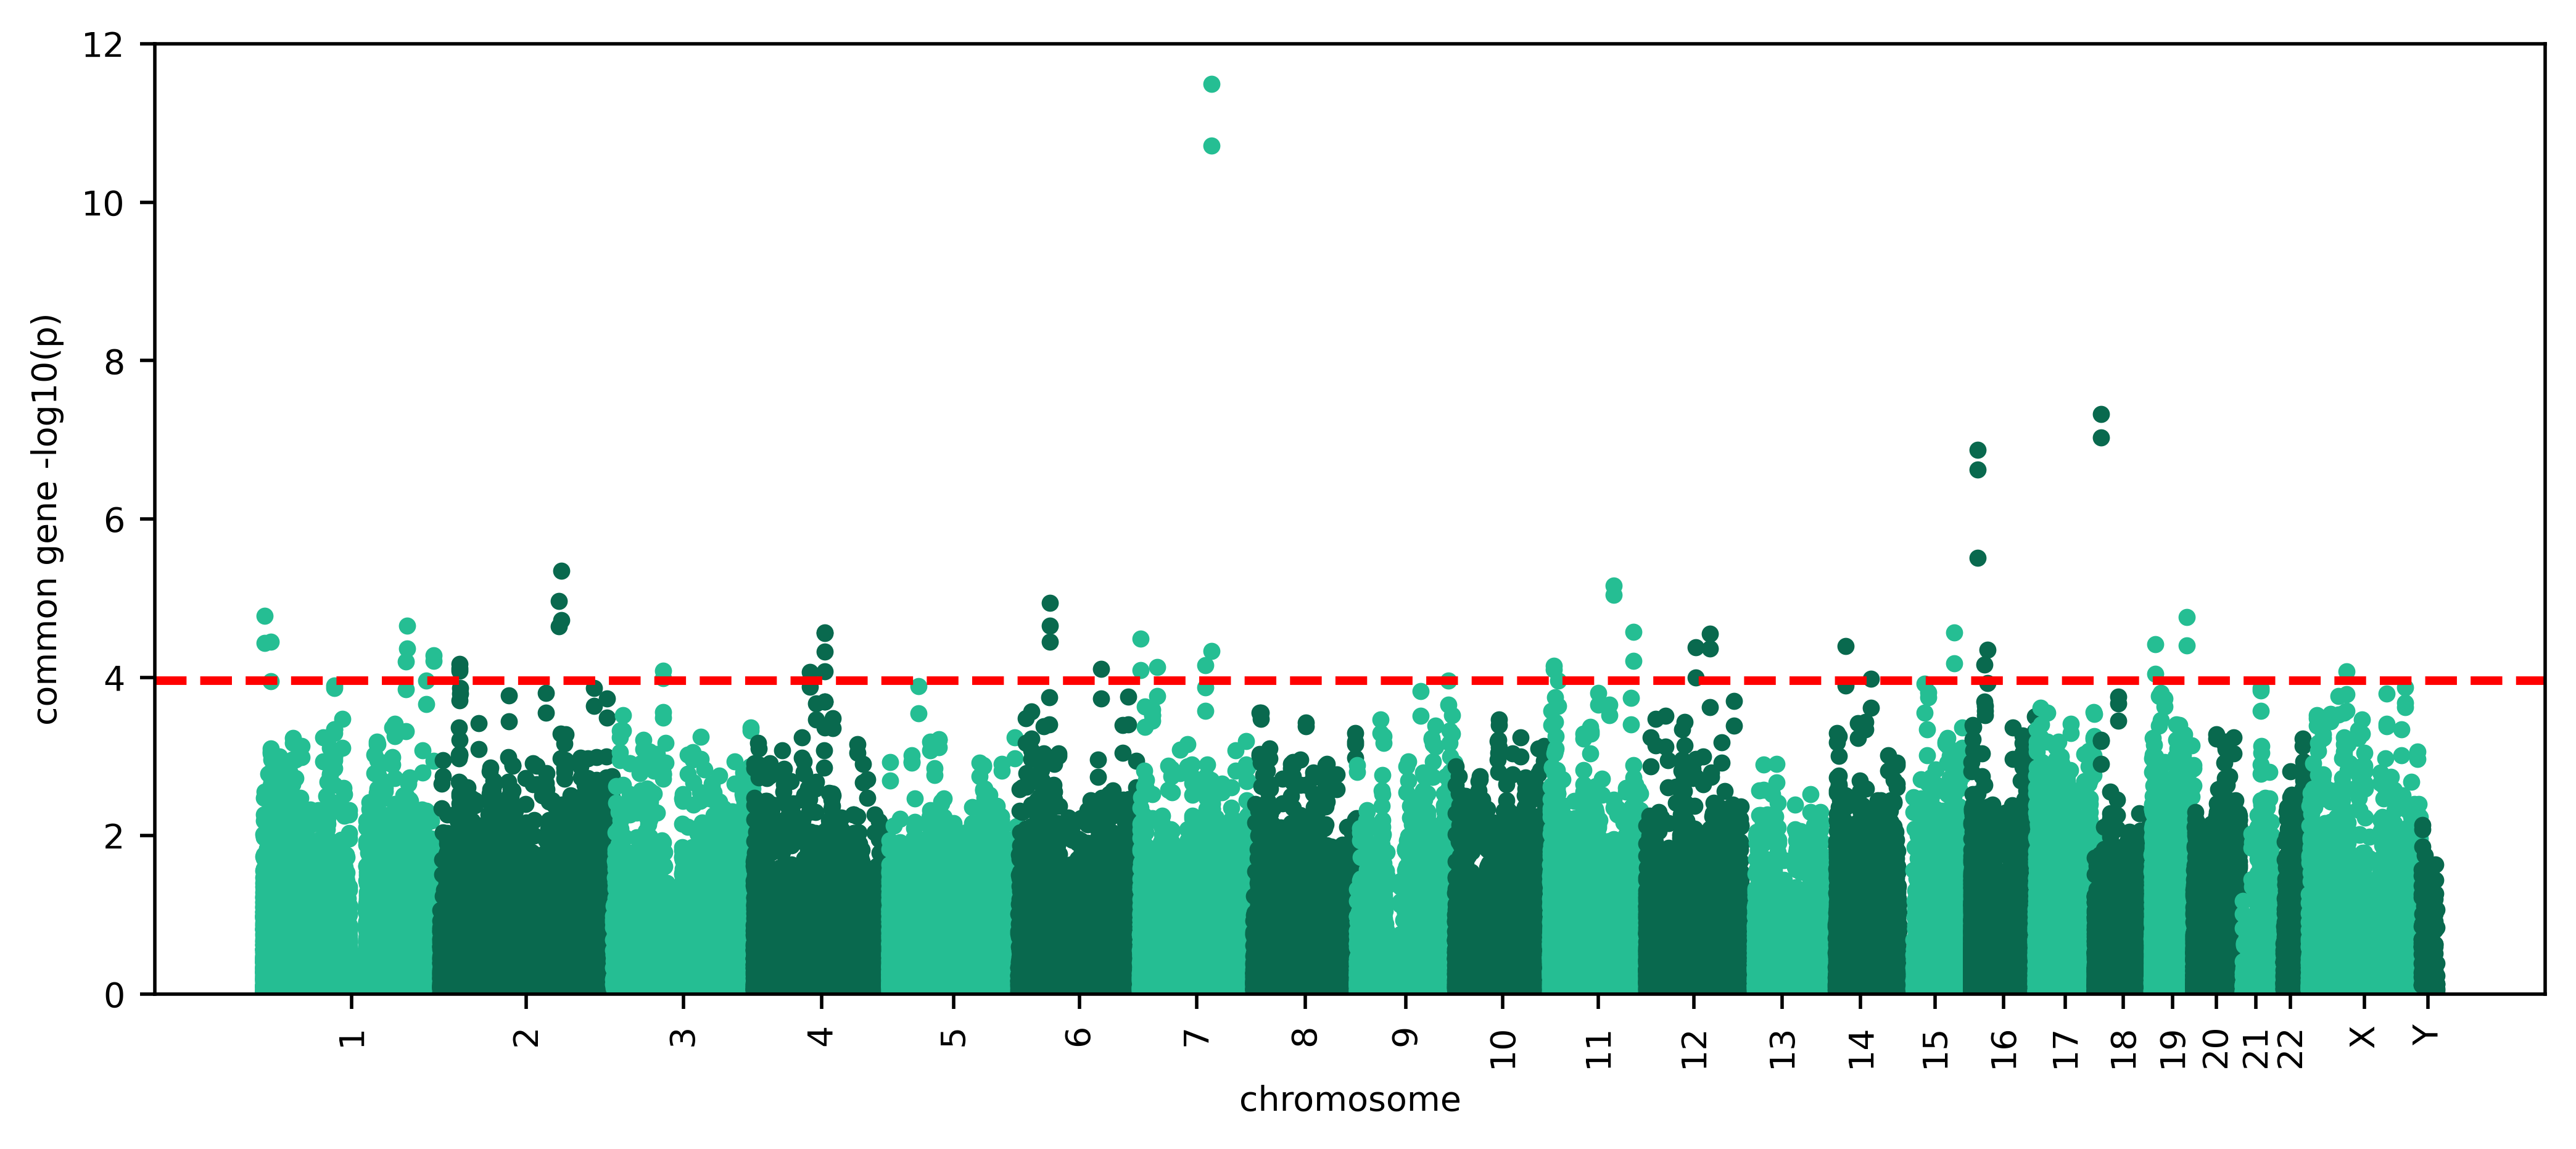

In [17]:
#used in graphical abstract
fig=plt.figure(figsize=(10,4))
#fig, ax=plt.subplots(figsize=(10,4))
manhattan(pval=rare_genes_exploded['pvals'],pos=rare_genes_exploded['Position'],chr=rare_genes_exploded['Chrom'],label='',
                    cut=0,lines=[-np.log10((FDR_burden_25))],lines_colors=['red'], colors=[color_dict['rare'], color_dict['rare_alt']],
                    lines_widths = [2], lines_styles = ["--"],
                   top=12, markersize=6, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('common gene -log10(p)')

#commented out- use to turn into miami plot
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')
if save_fig:
    plt.savefig('figures/' + 'rare_genes'+'_abstract'+'_500dpi.png',dpi=500,bbox_inches='tight')

# rare genes stacked barplots- Fig S2C

In [18]:
#subset tables for only genes that pass significance thresholds
rgenes_fdr25=rare_genes[(rare_genes['FDR_burden']<0.25)|
           (rare_genes['FDR_SKAT']<0.25)|
           (rare_genes['FDR_SKATO']<.25)]
rgenes_bonf=rare_genes[(rare_genes['P‑Value SKATO']<0.05/len(rare_genes))|
           (rare_genes['P‑Value SKAT']<0.05/len(rare_genes))|
           (rare_genes['P‑Value Burden']<0.05/len(rare_genes))]
#define dictionary of rare genes by test 
rare_gene_test={
    'misLC':list(set(rgenes_fdr25[rgenes_fdr25['Burden Set']=='missense|LC']['Gene Name'])),
'misLC_strin':list(set(rgenes_bonf[rgenes_bonf['Burden Set']=='missense|LC']['Gene Name'])),
'pLoF':list(set(rgenes_fdr25[rgenes_fdr25['Burden Set']=='pLoF']['Gene Name'])),
'pLoF_strin':list(set(rgenes_bonf[rgenes_bonf['Burden Set']=='pLoF']['Gene Name'])),
'syn':list(set(rgenes_fdr25[rgenes_fdr25['Burden Set']=='synonymous']['Gene Name'])),
'syn_strin':list(set(rgenes_bonf[rgenes_bonf['Burden Set']=='synonymous']['Gene Name']))}

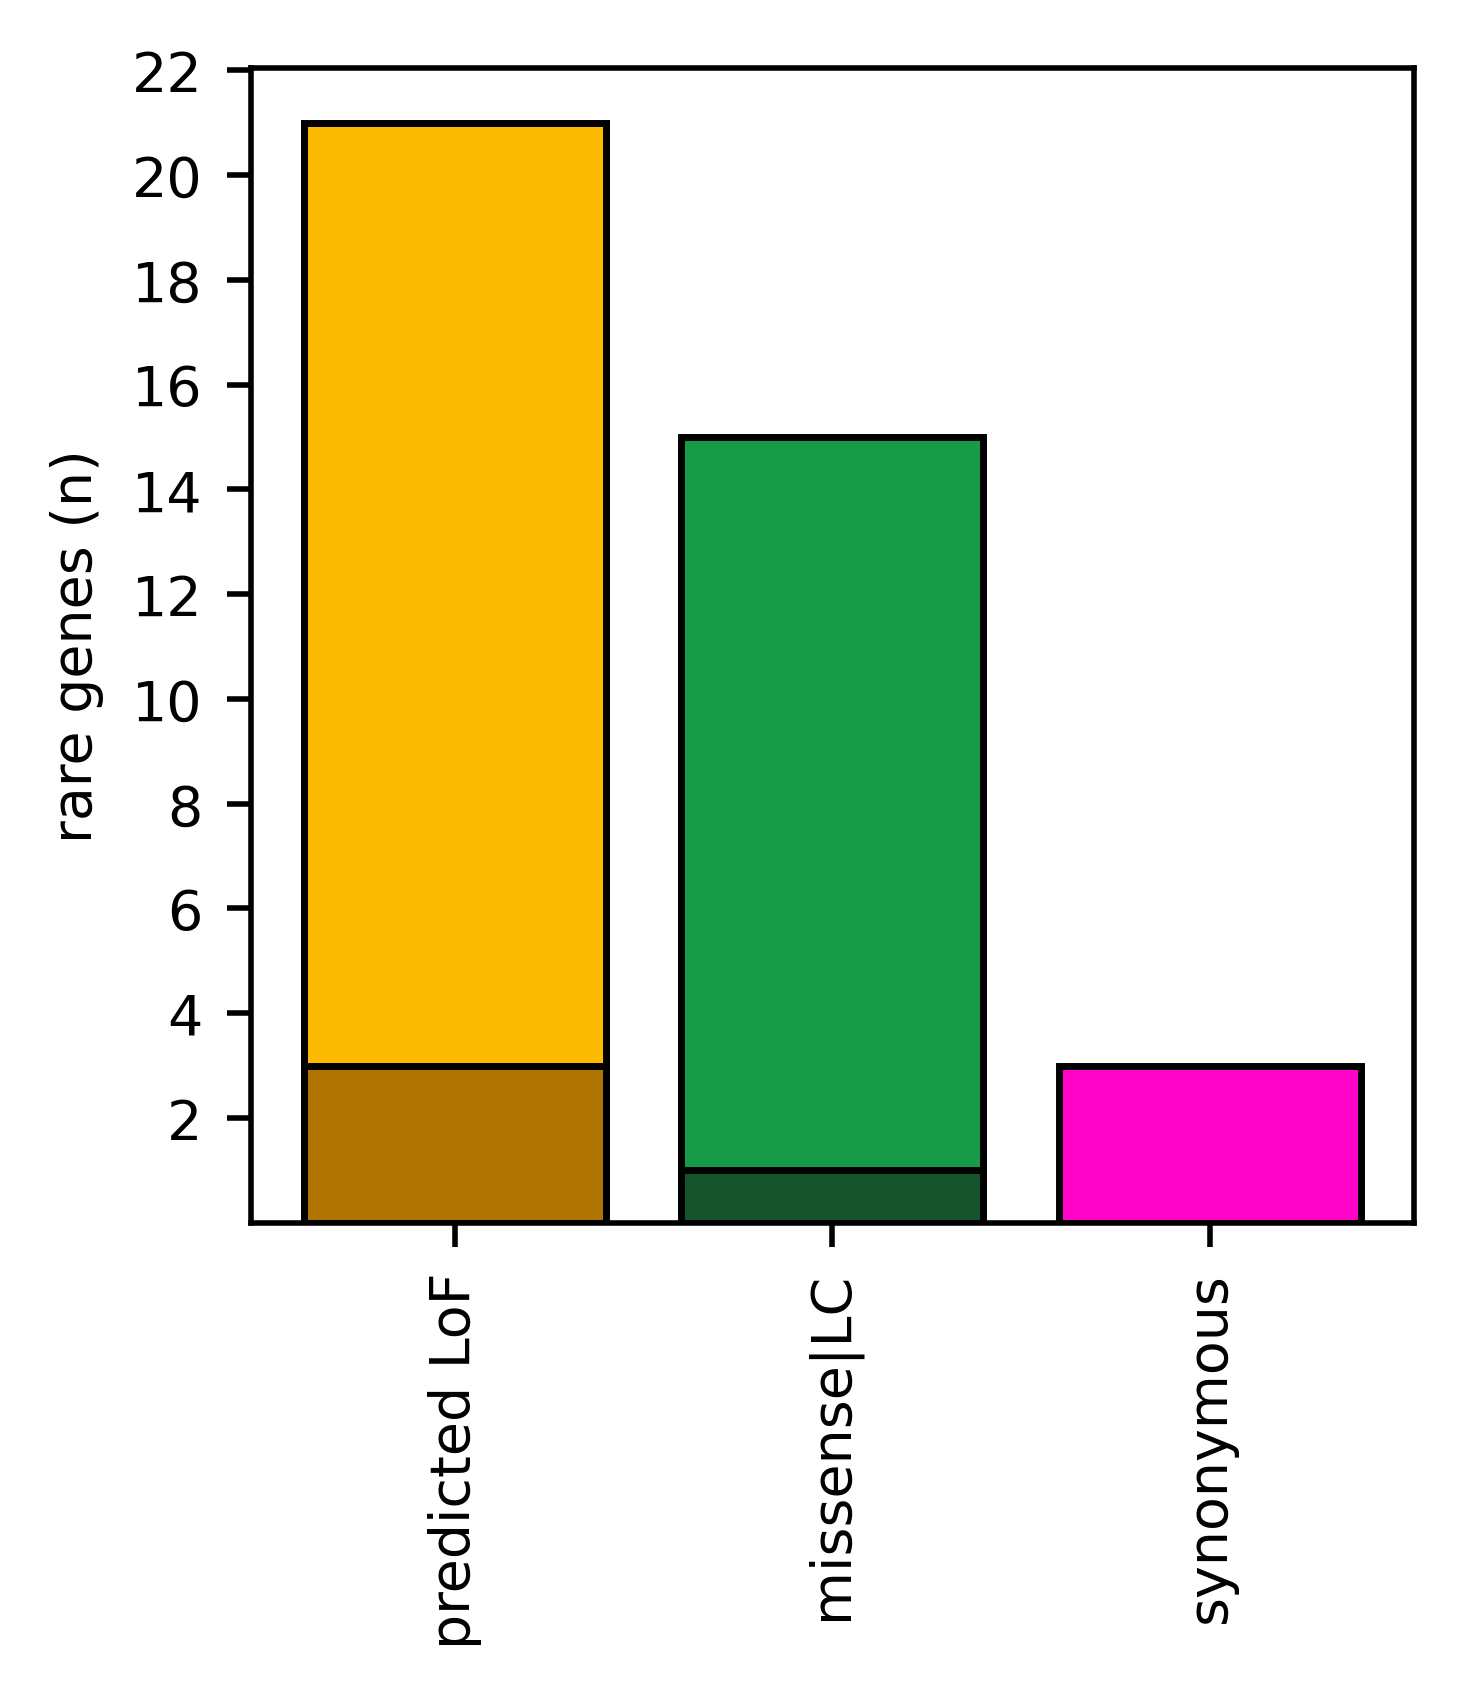

In [19]:
data=('predicted LoF','missense|LC','synonymous')
gene_counts = {
    "stringent": np.array([len(rare_gene_test['pLoF_strin']), len(rare_gene_test['misLC_strin']), len(rare_gene_test['syn_strin'])]),
    "lenient": np.array([len(rare_gene_test['pLoF']), len(rare_gene_test['misLC']), len(rare_gene_test['syn'])])
}

fig, ax = plt.subplots(figsize=(3, 3))
# Stacked bar chart
ax.bar(data, list(gene_counts['stringent']),
       color=[color_dict['pLoF_alt'],color_dict['misLC_alt'],color_dict['syn_alt']], edgecolor="black")
ax.bar(data, list(gene_counts['lenient']), bottom = list(gene_counts['stringent']),  
      color=([color_dict['pLoF'],color_dict['misLC'],color_dict['syn']]), edgecolor="black")
plt.yticks([2,4,6,8,10,12,14,16,18, 20, 22])
plt.xticks(rotation='vertical')
plt.ylabel("rare genes (n)")
if save_fig:
    plt.savefig('figures/' + 'rare_genes_'+'stacked'+'_barplot.svg',bbox_inches='tight')

# rare genes venn diagram by test- Fig S2B

In [20]:
b=set(rgenes_fdr25[rgenes_fdr25['FDR_burden']<0.25]['Gene Name'])
sk=set(rgenes_fdr25[rgenes_fdr25['FDR_SKATO']<0.25]['Gene Name'])
s=set(rgenes_fdr25[rgenes_fdr25['FDR_SKAT']<0.25]['Gene Name'])

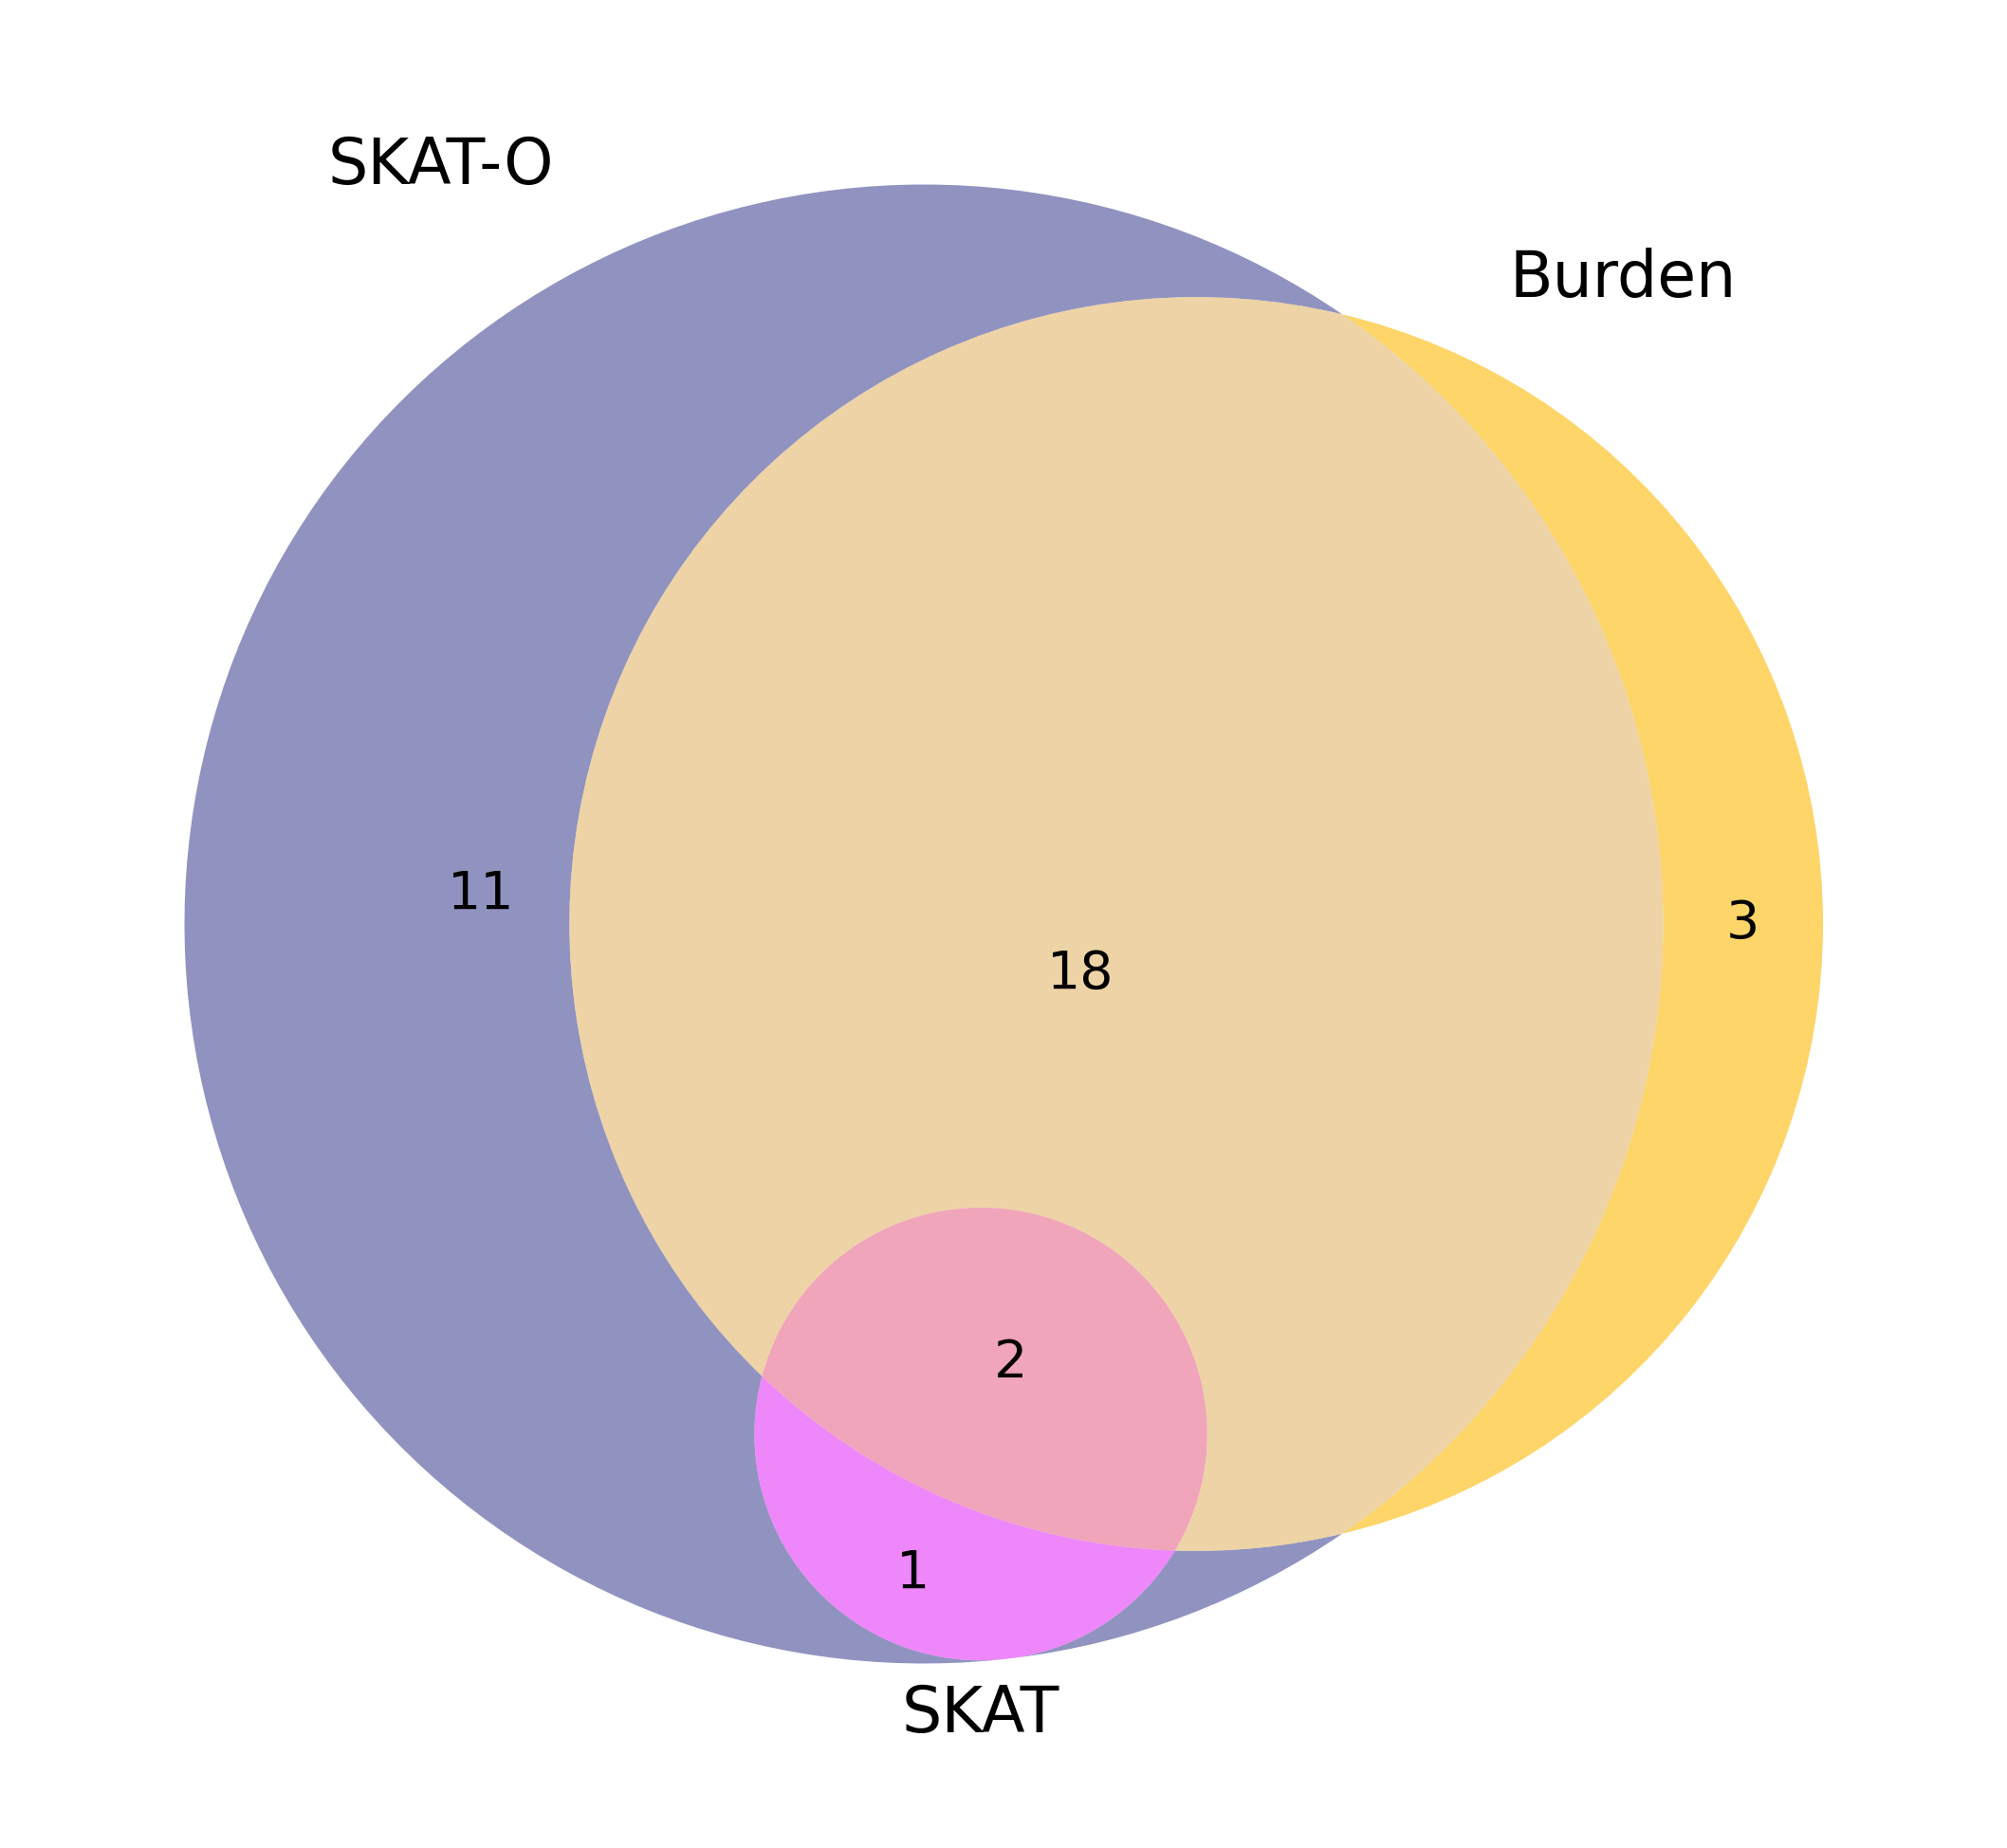

In [21]:
venn_rare_test(sk,b,s,['SKAT-O','Burden','SKAT'],[color_dict['SKAT-O'],color_dict['burden'],color_dict['SKAT']],save_fig)